In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [7]:
df = pd.read_csv("DBtrainrides_final_result.csv")

In [8]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('../utils')))  # Add the parent directory to the path

from utils.utils import fill_missing_times, normalize_dates, ordinal_scaling

In [9]:
message_order = ['No message', 'Information', 'Bauarbeiten', 'Störung', 'Großstörung']
df = ordinal_scaling(df, "transformed_info_message", "label_info_encoded", message_order)
df = normalize_dates(df)

df

In [10]:
df.to_csv("DBtrainrides_normalised.csv", index=False)

In [11]:
# df = pd.read_csv("DBtrainrides_normalised.csv")

In [12]:
target = df["arrival_delay_m"]
unique_base_ids = df['ID_Base'].unique()
np.random.seed(42)  # For reproducibility, if desired
shuffled_ids = np.random.permutation(unique_base_ids)
split_index = int(0.8 * len(shuffled_ids))

base_ids_80 = shuffled_ids[:split_index]  # 80% of Base_IDs
base_ids_20 = shuffled_ids[split_index:]  # 20% of Base_IDs

# Step 3: Split the dataframe based on the Base_ID sets
X_train = df[df['ID_Base'].isin(base_ids_80)]
X_test = df[df['ID_Base'].isin(base_ids_20)]

y_train = X_train["arrival_delay_m"]
y_test = X_test["arrival_delay_m"] 

X_train = X_train.drop(columns=["arrival_delay_m", "transformed_info_message","arrival_plan","departure_plan"])

X_test = X_test.drop(columns=["arrival_delay_m", "transformed_info_message","arrival_plan","departure_plan"])

# 2. Model Training and Evaluation

## 2.1 Initial Model Training

In [13]:
# Train Decision Tree Regressor
regression_tree = DecisionTreeRegressor(max_depth=10, min_samples_leaf=5, max_leaf_nodes=10)
regression_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, max_leaf_nodes=10, min_samples_leaf=5)

In [14]:
# Predictions and evaluation
y_pred = regression_tree.predict(X_test)
mse = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mse)

Mean Absolute Error: 0.8174893341767202


Mean Absolute Error: 0.8174893341767202


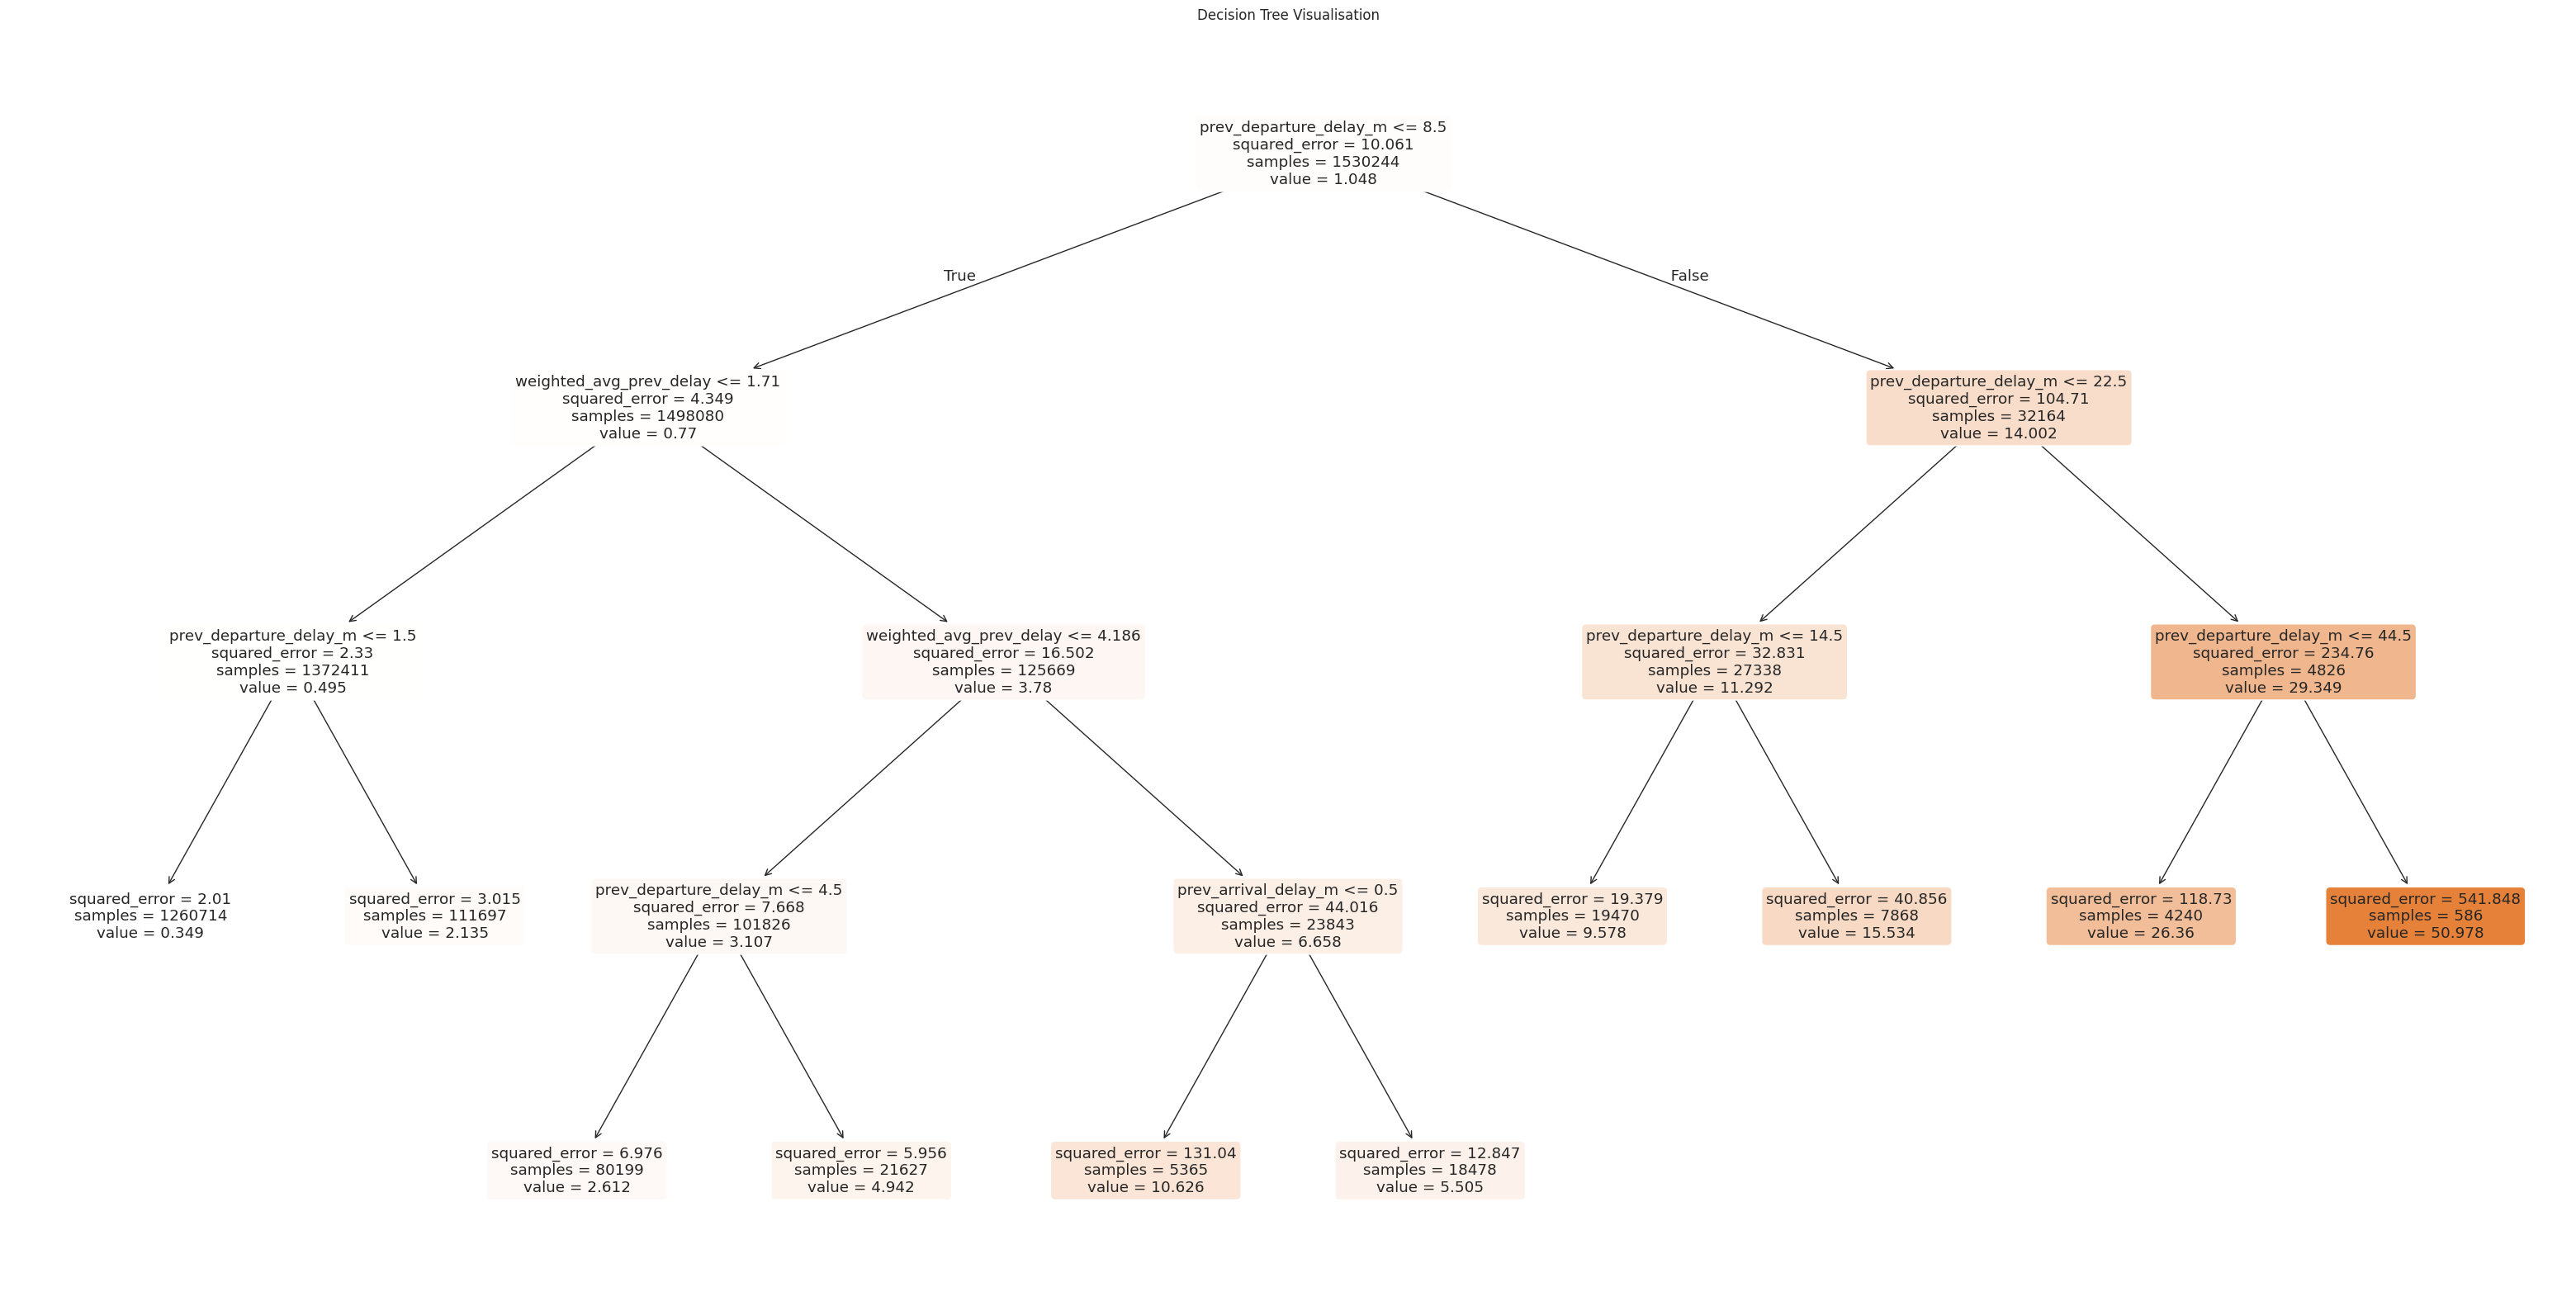

In [15]:
# Train Decision Tree Regressor
regression_tree = DecisionTreeRegressor(max_depth=10, min_samples_leaf=5, max_leaf_nodes=10)
regression_tree.fit(X_train, y_train)

# Predictions and evaluation
y_pred = regression_tree.predict(X_test)
mse = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mse)

# Visualise the Decision Tree
plt.figure(figsize=(40, 20))  # Adjust size for readability
plot_tree(
    regression_tree,
    feature_names=X_train.columns,
    filled=True,
    rounded=True
)
plt.title("Decision Tree Visualisation")
plt.show()

## 2.2 Feature Importance Visualisation

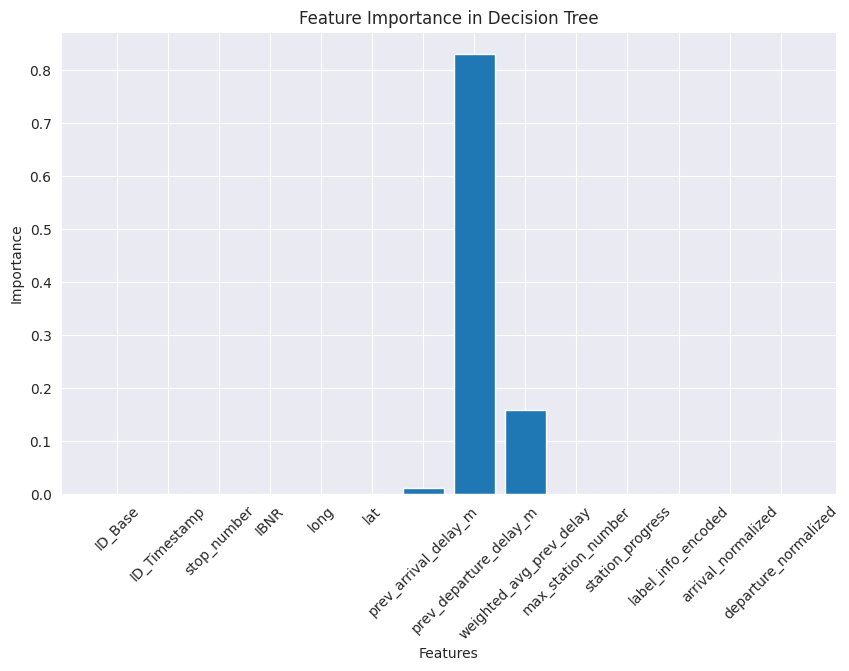

In [16]:
# Plot feature importance
feature_importances = regression_tree.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(X_train.columns, feature_importances)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance in Decision Tree")
plt.xticks(rotation=45)
plt.show()

## 2.3 Residual Analysis

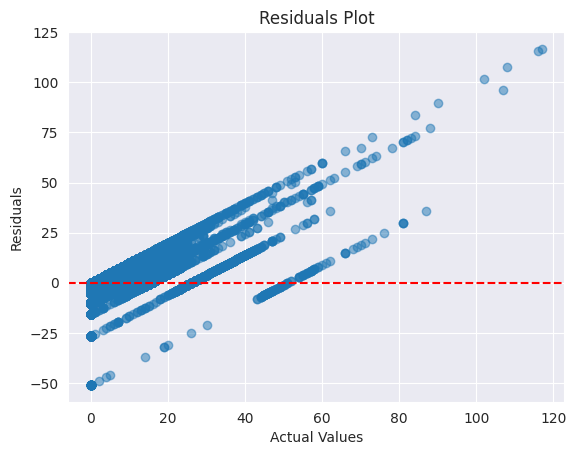

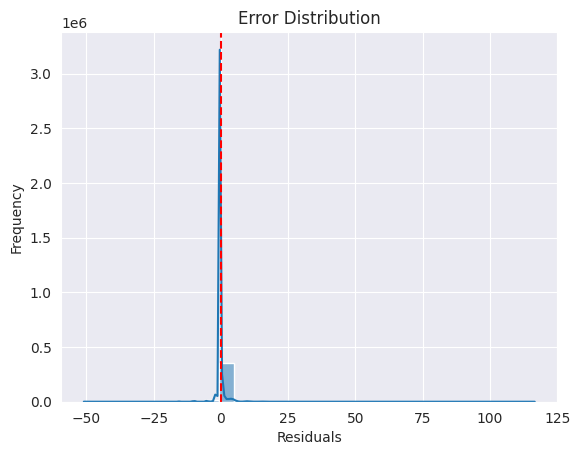

In [17]:
# Residuals plot
residuals = y_test - y_pred
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()

# Residual distribution
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(0, color='red', linestyle='--')
plt.title("Error Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

## 2.4 Model Performance Metrics

In [18]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}, R-squared: {r2:.4f}")

RMSE: 2.1038, R-squared: 0.5713


/root/.virtualenvs/DM-Project/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# 3. Model Tuning with Grid Search

In [19]:
# 3.1 Perform Grid Search for Hyperparameter Tuning
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'max_leaf_nodes': [10, 20, 15]
}

grid_search = GridSearchCV(
    estimator=regression_tree, 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Store the results
results = pd.DataFrame(grid_search.cv_results_)

## 3.1 Perform Grid Search for Hyperparameter Tuning

In [20]:
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'max_leaf_nodes': [10, 20, 15]
}

grid_search = GridSearchCV(
    estimator=regression_tree, 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Store the results
results = pd.DataFrame(grid_search.cv_results_)

## 3.2 Extract and Sort Hyperparameter Scores

In [21]:
# Extract parameters and their corresponding mean test scores
cv_params = results["params"]
cv_mean_test_score = results["mean_test_score"]

# Combine parameters and scores into a list of tuples
param_test_scores = [
    (str(cv_params[key]), float(cv_mean_test_score[key])) 
    for key in range(len(cv_params))
]

# Sort scores in descending order
param_test_scores = sorted(param_test_scores, key=lambda x: x[1], reverse=True)

# Display the top hyperparameter scores
param_test_scores[:10]  # Show the top 10 for readability

[("{'max_depth': 10, 'max_leaf_nodes': 20, 'min_samples_split': 2}",
  0.6357291676706962),
 ("{'max_depth': 10, 'max_leaf_nodes': 20, 'min_samples_split': 5}",
  0.6357291676706962),
 ("{'max_depth': 10, 'max_leaf_nodes': 20, 'min_samples_split': 10}",
  0.6357291676706962),
 ("{'max_depth': None, 'max_leaf_nodes': 20, 'min_samples_split': 2}",
  0.6357291676706962),
 ("{'max_depth': None, 'max_leaf_nodes': 20, 'min_samples_split': 5}",
  0.6357291676706962),
 ("{'max_depth': None, 'max_leaf_nodes': 20, 'min_samples_split': 10}",
  0.6357291676706962),
 ("{'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_split': 2}",
  0.6345144661756498),
 ("{'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_split': 5}",
  0.6345144661756498),
 ("{'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_split': 10}",
  0.6345144661756498),
 ("{'max_depth': 5, 'max_leaf_nodes': 15, 'min_samples_split': 2}",
  0.6281218424957427)]

## 3.3 Visualise Hyperparameter Tuning Results

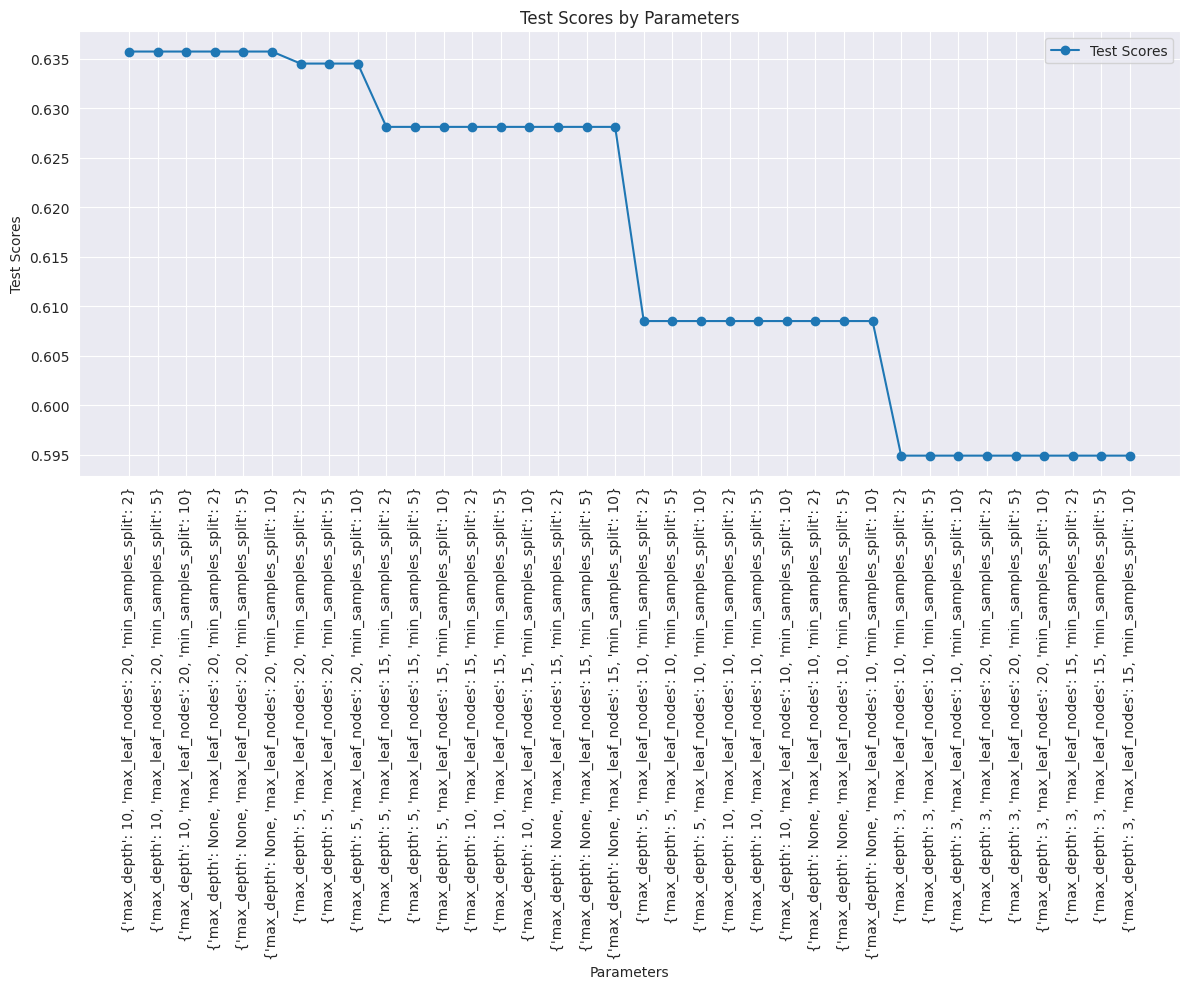

In [22]:
# Plot the test scores by parameters
plt.figure(figsize=(12, 10))
plt.plot(
    [param for param, _ in param_test_scores],  # x-axis: parameters
    [score for _, score in param_test_scores],  # y-axis: test scores
    marker='o', linestyle='-', label='Test Scores'
)

# Add labels, title, and rotate x-axis labels for better readability
plt.xlabel('Parameters')
plt.ylabel('Test Scores')
plt.title('Test Scores by Parameters')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

## 3.4 Evaluate the Best Model from Grid Search

In [23]:
# Retrieve the best model and its parameters
best_tree = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Use the best model for predictions
y_pred_best = best_tree.predict(X_test)

# Calculate performance metrics
mse_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = mean_squared_error(y_test, y_pred_best, squared=False)
r2_best = r2_score(y_test, y_pred_best)

print(f"Best Model MAE: {mse_best:.4f}")
print(f"Best Model RMSE: {rmse_best:.4f}")
print(f"Best Model R-squared: {r2_best:.4f}")


Best Parameters: {'max_depth': 10, 'max_leaf_nodes': 20, 'min_samples_split': 2}
Best Model MAE: 0.7516
Best Model RMSE: 2.0428
Best Model R-squared: 0.5958


/root/.virtualenvs/DM-Project/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## 3.5 Visualise the Best Decision Tree

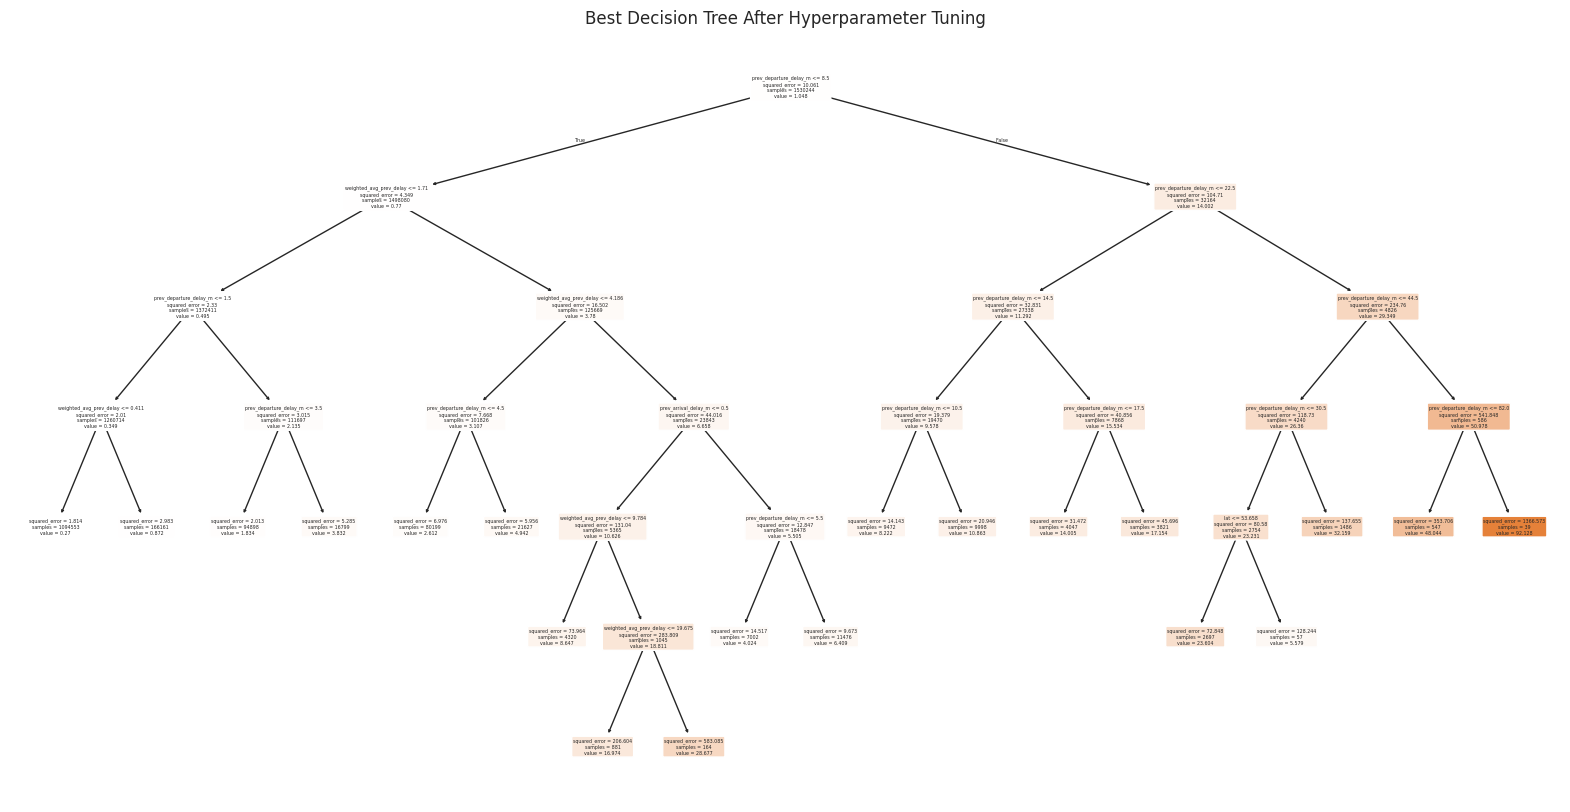

In [24]:
# Visualise the decision tree with the best hyperparameters
plt.figure(figsize=(20, 10))
plot_tree(
    best_tree,
    feature_names=X_train.columns,
    filled=True,
    rounded=True
)
plt.title("Best Decision Tree After Hyperparameter Tuning")
plt.show()

## 3.6 Residual Analysis (After Hyperparameter Tuning)

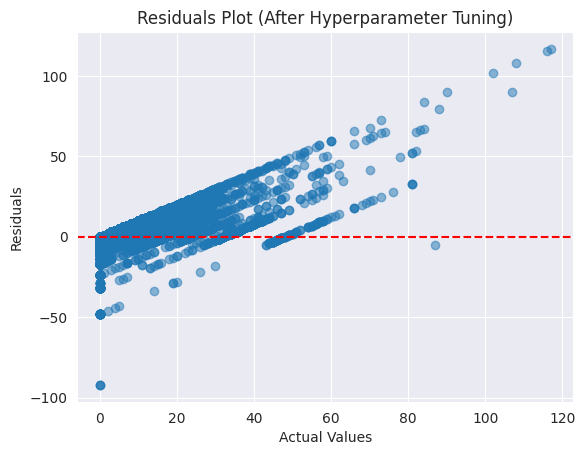

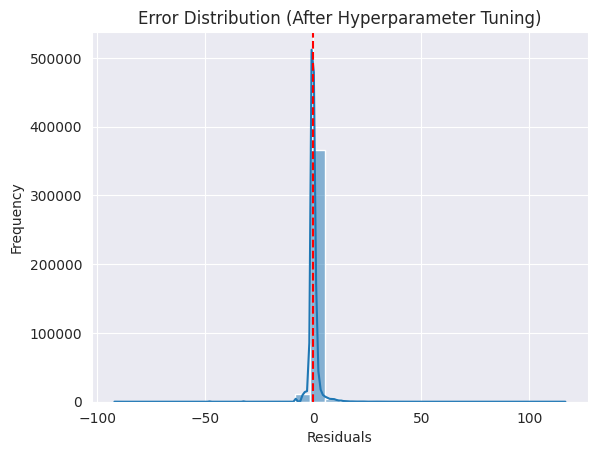

In [25]:
# Residuals plot
residuals_best = y_test - y_pred_best
plt.scatter(y_test, residuals_best, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot (After Hyperparameter Tuning)")
plt.show()

# Residual distribution
sns.histplot(residuals_best, kde=True, bins=30)
plt.axvline(0, color='red', linestyle='--')
plt.title("Error Distribution (After Hyperparameter Tuning)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

## 3.7 Feature Importance Analysis (After Hyperparameter Tuning)

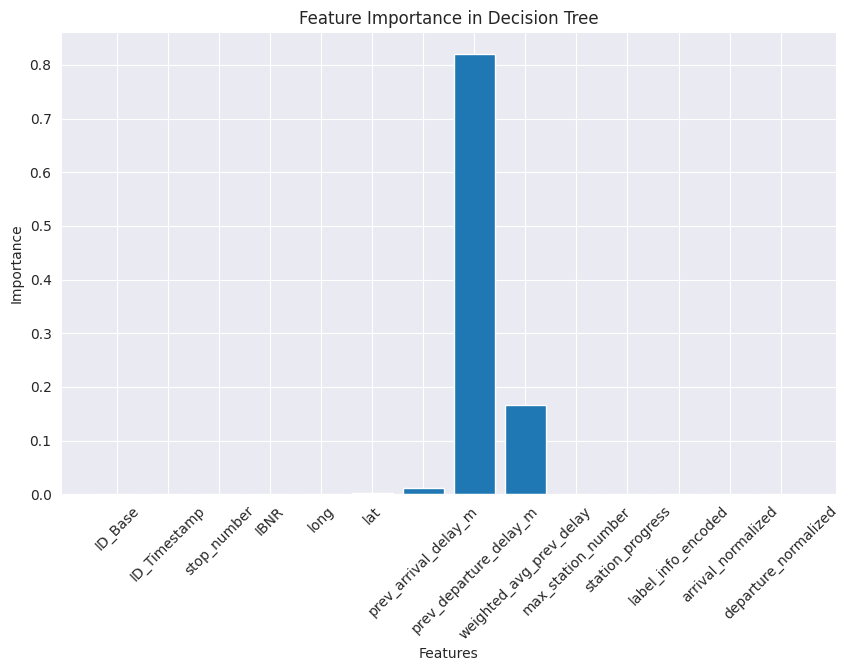

In [28]:
# Plot feature importance
feature_importances = best_tree.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(X_train.columns, feature_importances)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance in Decision Tree")
plt.xticks(rotation=45)
plt.show()

## 4. Cross-Validation and Learning Curve Analysis

Cross-Validation MAE: 0.8123 ± 0.0062


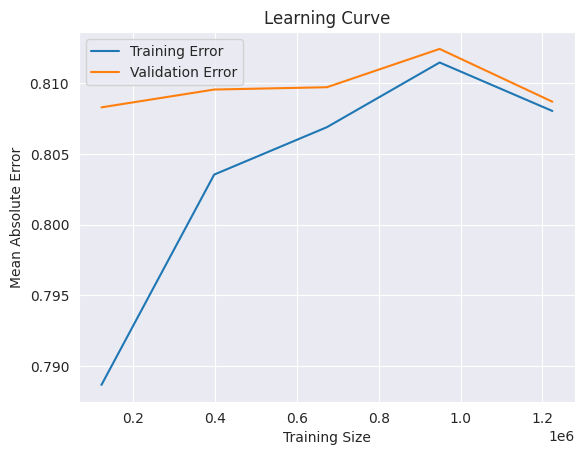

In [26]:
# Cross-validation with MAE
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(regression_tree, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
mean_cv_mae = -np.mean(cv_scores)
std_cv_mae = np.std(cv_scores)
print(f"Cross-Validation MAE: {mean_cv_mae:.4f} ± {std_cv_mae:.4f}")

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(
    regression_tree, X_train, y_train, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1
)
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label="Training Error")
plt.plot(train_sizes, test_scores_mean, label="Validation Error")
plt.xlabel("Training Size")
plt.ylabel("Mean Absolute Error")
plt.title("Learning Curve")
plt.legend()
plt.show()

# 5. Model Performance Comparison (Before and After Hyperparameter Tuning)

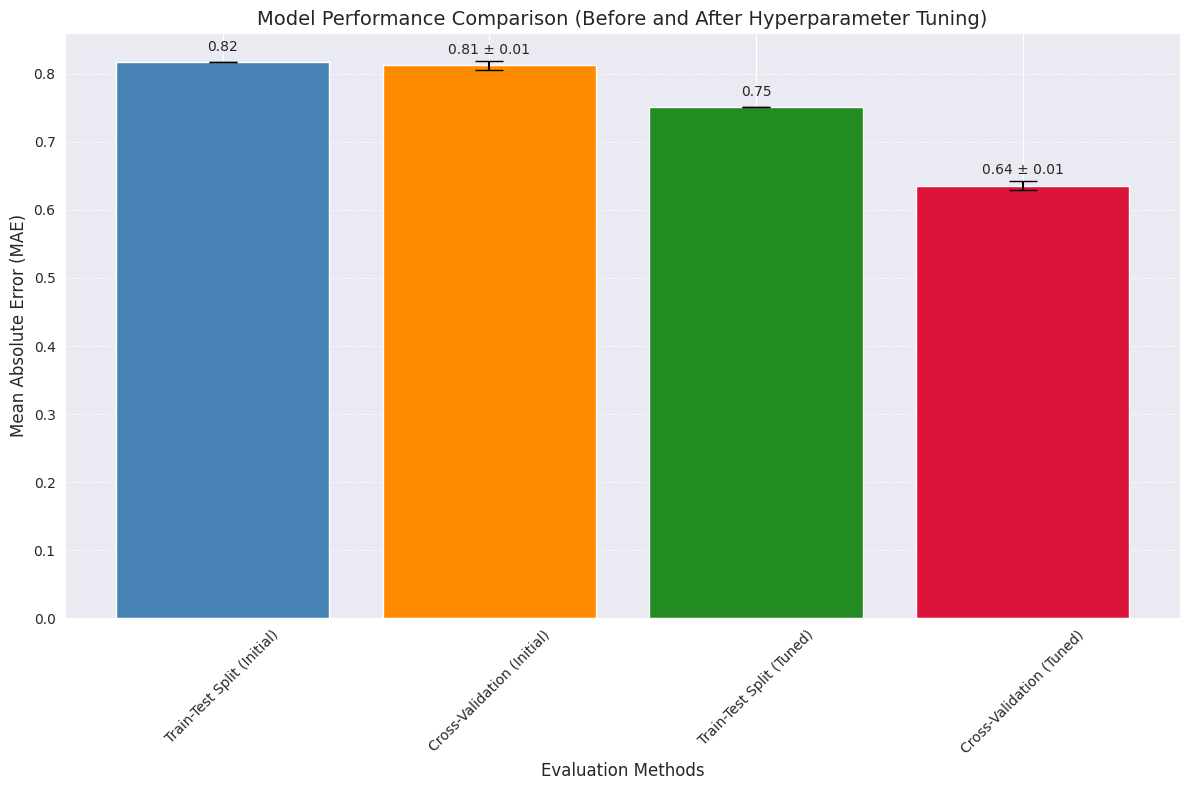

In [27]:
# Define metrics and corresponding values for comparison
metrics = [
    'Train-Test Split (Initial)', 
    'Cross-Validation (Initial)', 
    'Train-Test Split (Tuned)', 
    'Cross-Validation (Tuned)'
]
values = [mse, mean_cv_mae, mse_best, grid_search.best_score_]
errors = [0, std_cv_mae, 0, std_cv_mae]  # Error bars for cross-validation metrics

# Plot the comparison with enhanced visualisation
plt.figure(figsize=(12, 8))

# Use a bar chart with distinct colours and error bars
plt.bar(
    metrics, 
    values, 
    yerr=errors, 
    capsize=10, 
    color=['steelblue', 'darkorange', 'forestgreen', 'crimson']
)

# Add precise data labels on each bar
for i, (val, err) in enumerate(zip(values, errors)):
    plt.text(
        i, 
        val + (0.02 * max(values)),  # Slightly above the bar for visibility
        f"{val:.2f}" + (f" ± {err:.2f}" if err != 0 else ""),  # Show error if available
        ha='center', 
        fontsize=10
    )

# Add labels and title with improved readability
plt.ylabel('Mean Absolute Error (MAE)', fontsize=12)
plt.xlabel('Evaluation Methods', fontsize=12)
plt.title('Model Performance Comparison (Before and After Hyperparameter Tuning)', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout for neatness
plt.tight_layout()
plt.show()